In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             ConfusionMatrixDisplay, RocCurveDisplay)

In [9]:
train_df = pd.read_pickle("train.pkl")
test_df = pd.read_pickle("test.pkl")

In [10]:
X_train = train_df.drop("label", axis=1)
y_train = train_df["label"]

X_test = test_df.drop("label", axis=1)
y_test = test_df["label"]

In [11]:
n_runs = 20

In [ ]:
# Definição do pipeline com StackingClassifier
pipeline_stack = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', StackingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier()),
            ('rf', RandomForestClassifier(random_state=42)),
            ('lgbm', LGBMClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(random_state=42)
    ))
])

param_dist_stack = {
    # Hiperparâmetros do estimador final (LogisticRegression)
    'stack__final_estimator__C': [0.01, 0.1, 1, 10, 100],
    'stack__final_estimator__penalty': ['l2'],  # LogisticRegression utiliza L2 por padrão

    # Hiperparâmetros do KNN base
    'stack__knn__n_neighbors': list(range(1, 21)),

    # Hiperparâmetros da Random Forest base
    'stack__rf__n_estimators': [50, 100, 150],
    
    # Hiperparâmetros do LGBM base (por exemplo, número de folhas)
    'stack__lgbm__num_leaves': [31, 50, 70]
}

# Configurando a validação cruzada estratificada (k=5)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [13]:
best_scores_stack = []         # Armazena o F1 no teste de cada rodada
best_params_stack = []         # Armazena os melhores hiperparâmetros de cada rodada
cv_results_history_stack = []  # Armazena o histórico cv_results_ de cada rodada

for i in range(n_runs):
    print(f"\nRodada {i+1}/{n_runs}")
    
    stack_search = RandomizedSearchCV(
        estimator=pipeline_stack,
        param_distributions=param_dist_stack,
        n_iter=4,                 # 20 iterações por rodada
        scoring='f1_macro',        # Métrica principal
        cv=cv,
        random_state=42 + i,       # Variação da semente para cada rodada
        n_jobs=-1,
        verbose=1
    )
    
    stack_search.fit(X_train, y_train)
    
    # Armazenando o histórico da validação cruzada
    cv_results = pd.DataFrame(stack_search.cv_results_)
    cv_results_history_stack.append(cv_results)
    
    # Avaliação no conjunto de teste
    best_model_stack = stack_search.best_estimator_
    y_pred_test = best_model_stack.predict(X_test)
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    
    best_scores_stack.append(f1_test)
    best_params_stack.append(stack_search.best_params_)
    
    print("Melhores hiperparâmetros:", stack_search.best_params_)
    print("Melhor F1 (validação cruzada - média):", stack_search.best_score_)
    print("F1 no Teste:", f1_test)



Rodada 1/20
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 19697, number of negative: 19697
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20130
[LightGBM] [Info] Number of data points in the train set: 39394, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15758, number of negative: 15757
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19887
[LightGBM] [Info] Number of data points in the train set: 31515, number of used features: 

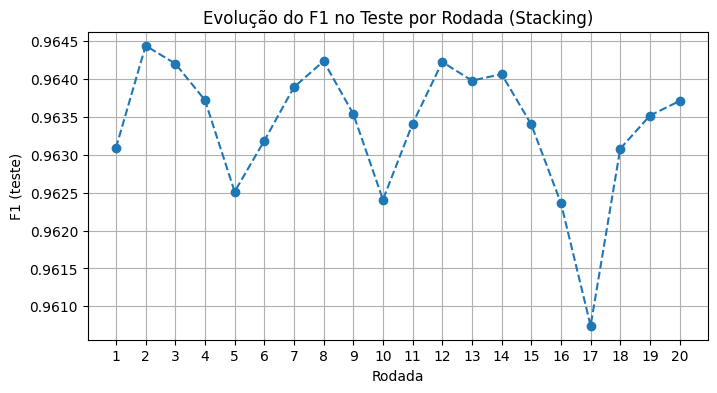

In [14]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_runs+1), best_scores_stack, marker='o', linestyle='--')
plt.title("Evolução do F1 no Teste por Rodada (Stacking)")
plt.xlabel("Rodada")
plt.ylabel("F1 (teste)")
plt.xticks(range(1, n_runs+1))
plt.grid(True)
plt.show()


In [15]:
best_run_index = np.argmax(best_scores_stack)
print(f"Melhor rodada: {best_run_index + 1}")
print(f"F1 nessa rodada: {best_scores_stack[best_run_index]}")
print("Melhores hiperparâmetros:", best_params_stack[best_run_index])


Melhor rodada: 2
F1 nessa rodada: 0.9644414170091202
Melhores hiperparâmetros: {'stack__rf__n_estimators': 150, 'stack__lgbm__num_leaves': 50, 'stack__knn__n_neighbors': 16, 'stack__final_estimator__penalty': 'l2', 'stack__final_estimator__C': 0.1}


In [16]:
melhores_parametros = best_params_stack[best_run_index]

# Reconstruindo o pipeline com os hiperparâmetros otimizados
best_stack_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('stack', StackingClassifier(
        estimators=[
            ('knn', KNeighborsClassifier()),
            ('rf', RandomForestClassifier(random_state=42)),
            ('lgbm', LGBMClassifier(random_state=42))
        ],
        final_estimator=LogisticRegression(
            C=melhores_parametros['stack__final_estimator__C'],
            penalty=melhores_parametros['stack__final_estimator__penalty'],
            random_state=42
        )
    ))
])

# Ajustando hiperparâmetros dos estimadores base
# Note que o RandomForestClassifier e o LGBMClassifier dentro do StackingClassifier 
# não recebem os parâmetros diretamente via o pipeline final. Em alguns casos, pode ser 
# necessário reconstruir o StackingClassifier manualmente para definir estes parâmetros.
# Aqui, vamos utilizar o método set_params:
best_stack_pipeline.set_params(**{
    'stack__knn__n_neighbors': melhores_parametros['stack__knn__n_neighbors'],
    'stack__rf__n_estimators': melhores_parametros['stack__rf__n_estimators'],
    'stack__lgbm__num_leaves': melhores_parametros['stack__lgbm__num_leaves']
})

best_stack_pipeline.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 19697, number of negative: 19697
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20130
[LightGBM] [Info] Number of data points in the train set: 39394, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 15758, number of negative: 15757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19887
[LightGBM] [Info] Number of data points in the train set: 31515, number of used features: 143
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
[LightGBM] [Info] Number of positive: 15758, number of negative: 

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('stack',
                 StackingClassifier(estimators=[('knn',
                                                 KNeighborsClassifier(n_neighbors=16)),
                                                ('rf',
                                                 RandomForestClassifier(n_estimators=150,
                                                                        random_state=42)),
                                                ('lgbm',
                                                 LGBMClassifier(num_leaves=50,
                                                                random_state=42))],
                                    final_estimator=LogisticRegression(C=0.1,
                                                                       random_state=42)))])

Desempenho no Conjunto de Teste:
Acurácia : 0.9708
Precisão : 0.9623
Recall   : 0.9666
F1-score : 0.9644
AUC      : 0.9951


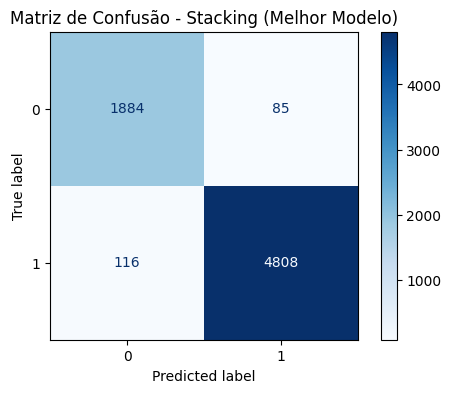

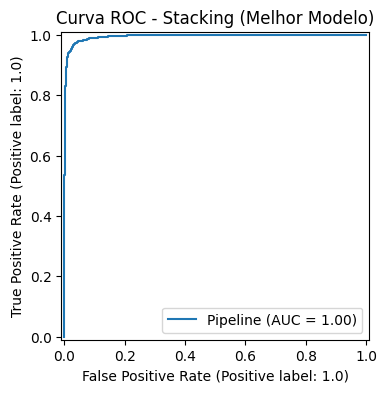


Relatório de Classificação:
              precision    recall  f1-score   support

        -1.0       0.94      0.96      0.95      1969
         1.0       0.98      0.98      0.98      4924

    accuracy                           0.97      6893
   macro avg       0.96      0.97      0.96      6893
weighted avg       0.97      0.97      0.97      6893



In [17]:
y_pred = best_stack_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print("Desempenho no Conjunto de Teste:")
print(f"Acurácia : {acc:.4f}")
print(f"Precisão : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

# Para problemas binários, calcular AUC
try:
    y_proba = best_stack_pipeline.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    print(f"AUC      : {auc:.4f}")
except ValueError:
    print("Não foi possível calcular AUC (possivelmente problema multiclasse).")

# Plot da Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax, cmap='Blues')
plt.title("Matriz de Confusão - Stacking (Melhor Modelo)")
plt.show()

# Plot da Curva ROC (apenas para problemas binários)
try:
    fig_roc, ax_roc = plt.subplots(figsize=(6, 4))
    RocCurveDisplay.from_estimator(best_stack_pipeline, X_test, y_test, ax=ax_roc)
    plt.title("Curva ROC - Stacking (Melhor Modelo)")
    plt.show()
except ValueError:
    print("Não foi possível gerar a Curva ROC (possivelmente problema multiclasse).")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))
